In [1]:
import pandas as pd
import seaborn as sns
import pandas_gbq
import tqdm
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file(
    'trumid-case-8a70bafcd63d.json',
)
pandas_gbq.context.credentials = credentials

In [2]:
# Update the in-memory credentials cache (added in pandas-gbq 0.7.0).
pandas_gbq.context.credentials = credentials
pandas_gbq.context.project = "trumid-case"

# Question 1: 

Assess the profitability of each product category. Are there significant differences between
them? If so, what might TheLook consider changing about its product mix to increase margins
overall?

## Data Exploration

 *  In `products`, are both `ID` and `sku` unique? **Yes**
 *  Does every item in `inventory_items` have a corresponding record in `products`? **Yes**
 *  Does the `cost` in `products` always match the cost in `inventory items`? **Yes**
 *  Does the `sale price` in `products` always match the `retail price` in `order items`? **Yes** <- So no sales?
 *  How often are items sold at below list price? (i.e. at a discount?) <- **Never! See above**
 *  Does every item in `order_items` have a corresponding record in `products`? **Yes**
 *  What does the distribution of profit margin look like within a given product category? Average for a product category? **Done**
 *  Define profitability - profit made per unit; compare what you would expect at full price v. actual **Done**
 *  Also consider contribution to total profits (fulfilled and NOT returned) 


In [6]:
# Are skus and ids unique?
query = """
SELECT
    count(DISTINCT id) as unique_ids
    , count(distinct sku) unique_skus
FROM
    `trumid-case.thelook_ecommerce.products`
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,unique_ids,unique_skus
0,29120,29120


In [10]:
# Are skus and ids unique?
query = """
SELECT
    count(DISTINCT CONCAT(id,'-',sku)) as unique_ids
FROM
    `trumid-case.thelook_ecommerce.products`
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,unique_ids
0,29120


In [25]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,order_id
    ,product_id
    ,sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items`
),
thelook_inventory_items AS (
SELECT
    id as inventory_id
    ,product_id
    ,product_sku
    ,cost
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
)
SELECT
   thelook_products.product_id
   ,thelook_products.sku
   ,thelook_products.cost as product_cost
   ,thelook_inventory_items.inventory_id
   ,thelook_inventory_items.cost as inventory_cost
FROM
    thelook_products
INNER JOIN
    thelook_inventory_items
ON
    thelook_products.product_id = thelook_inventory_items.product_id
AND
    thelook_products.sku = thelook_inventory_items.product_sku
"""
product_cost = pandas_gbq.read_gbq(query)
product_cost.query('product_cost != inventory_cost')

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,product_id,sku,product_cost,inventory_id,inventory_cost


In [29]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,order_id
    ,product_id
    ,sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items`
),
thelook_inventory_items AS (
SELECT
    id as inventory_id
    ,product_id
    ,product_sku
    ,cost
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
)
SELECT
   thelook_products.product_id
   ,thelook_products.sku
   ,thelook_orderitems.order_item_id
   ,thelook_products.retail_price
   ,thelook_orderitems.sale_price
FROM
    thelook_products
INNER JOIN
    thelook_orderitems
ON
    thelook_products.product_id = thelook_orderitems.product_id
"""
product_revenue = pandas_gbq.read_gbq(query)
product_revenue.query('retail_price != sale_price')

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,product_id,sku,order_item_id,retail_price,sale_price


In [33]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku as product_sku
    ,cost as product_cost
    ,category as product_category
    ,name as product_name
    ,brand as product_brand
    ,retail_price
    ,department
    ,retail_price - cost AS gross_profit
    ,((retail_price - cost)*1.00)/(retail_price*1.00) AS profit_margin
FROM
    `trumid-case.thelook_ecommerce.products`
)
SELECT
    *
FROM
    thelook_products

"""
product_with_margins = pandas_gbq.read_gbq(query)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [34]:
%matplotlib inline

In [44]:
product_with_margins.groupby([['product_id','product_category','profit_margin']]

,product_id,product_category,profit_margin
0,27569,Swim,0.384
1,27445,Swim,0.366
2,27457,Swim,0.424
3,27466,Swim,0.405
4,27481,Swim,0.360
...,...,...,...
29115,1993,Fashion Hoodies & Sweatshirts,0.575
29116,2062,Fashion Hoodies & Sweatshirts,0.524
29117,2308,Fashion Hoodies & Sweatshirts,0.499
29118,1852,Fashion Hoodies & Sweatshirts,0.488


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, 'Swim'),
  Text(1, 0, 'Jeans'),
  Text(2, 0, 'Pants'),
  Text(3, 0, 'Socks'),
  Text(4, 0, 'Active'),
  Text(5, 0, 'Shorts'),
  Text(6, 0, 'Sweaters'),
  Text(7, 0, 'Underwear'),
  Text(8, 0, 'Accessories'),
  Text(9, 0, 'Tops & Tees'),
  Text(10, 0, 'Sleep & Lounge'),
  Text(11, 0, 'Outerwear & Coats'),
  Text(12, 0, 'Suits & Sport Coats'),
  Text(13, 0, 'Fashion Hoodies & Sweatshirts'),
  Text(14, 0, 'Plus'),
  Text(15, 0, 'Suits'),
  Text(16, 0, 'Skirts'),
  Text(17, 0, 'Dresses'),
  Text(18, 0, 'Leggings'),
  Text(19, 0, 'Intimates'),
  Text(20, 0, 'Maternity'),
  Text(21, 0, 'Clothing Sets'),
  Text(22, 0, 'Pants & Capris'),
  Text(23, 0, 'Socks & Hosiery'),
  Text(24, 0, 'Blazers & Jackets'),
  Text(25, 0, 'Jumpsuits & Rompers')])

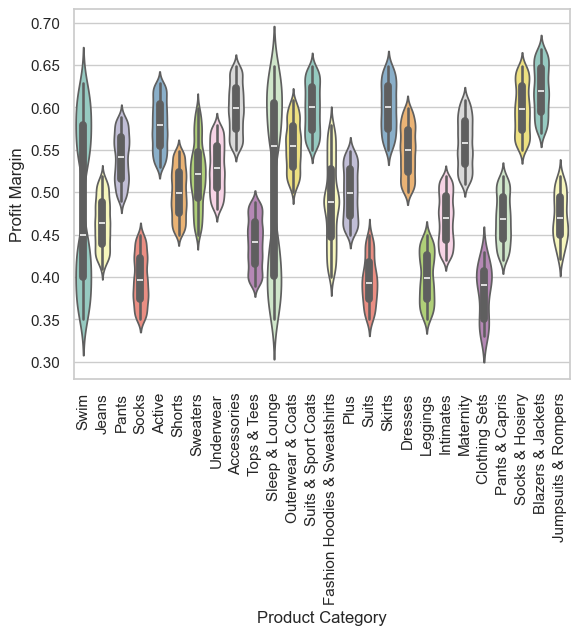

In [53]:
import matplotlib.pyplot as plt

sns.violinplot(data=product_with_margins, x='product_category', y='profit_margin',hue='product_category',palette="Set3")

# Set labels for the x and y axes
plt.xlabel('Product Category')
plt.ylabel('Profit Margin')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

### Now look at this against what's sold

- For items with biggest srpead of high v low margin, what doe sales look like?
- What areas are contributing most to profits? least?

In [60]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_order_items AS (
SELECT
    id as order_item_id
    ,product_id
    ,status
FROM
    `trumid-case.thelook_ecommerce.order_items`
)
SELECT
    status
    ,product_id
    ,COUNT(order_item_id) AS quantity
FROM
    thelook_order_items
GROUP BY
    status
    ,product_id
"""
volume_sold_by_status = pandas_gbq.read_gbq(query)
volume_sold_by_status['status'].unique()

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


array(['Complete', 'Shipped', 'Processing', 'Cancelled', 'Returned'],
      dtype=object)

In [61]:
volume_sold_by_status.head()

,status,product_id,quantity
0,Complete,12551,7
1,Complete,9518,6
2,Shipped,9137,6
3,Shipped,25244,7
4,Shipped,24932,6


In [5]:
products = pandas_gbq.read_gbq("SELECT * FROM `trumid-case.thelook_ecommerce.products`")
products.describe(include='all')

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
count,29120.0,29120.000000,29120,29118,29096,29120.000000,29120,29120,29120.0
unique,<NA>,NaN,26,27309,2756,NaN,2,29120,<NA>
top,<NA>,NaN,Intimates,Wrangler Men's Premium Performance Cowboy Cut ...,Allegra K,NaN,Women,B23C5765E165D83AA924FA8F13C05F25,<NA>
freq,<NA>,NaN,2363,8,1034,NaN,15989,1,<NA>
mean,14560.5,28.481774,NaN,NaN,NaN,59.220164,NaN,NaN,4.982898
std,8406.364256,30.624681,NaN,NaN,NaN,65.888927,NaN,NaN,2.901153
min,1.0,0.008300,NaN,NaN,NaN,0.020000,NaN,NaN,1.0
25%,7280.75,11.275613,NaN,NaN,NaN,24.000000,NaN,NaN,2.0
50%,14560.5,19.675081,NaN,NaN,NaN,39.990002,NaN,NaN,5.0
75%,21840.25,34.440000,NaN,NaN,NaN,69.949997,NaN,NaN,8.0


In [3]:

# The credentials and project_id arguments can be omitted.
pandas_gbq.read_gbq("SELECT * FROM `trumid-case.thelook_ecommerce.products` LIMIT 100")

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,27569,92.652563,Swim,2XU Men's Swimmers Compression Long Sleeve Top,2XU,150.410004,Men,B23C5765E165D83AA924FA8F13C05F25,1
1,27445,24.719661,Swim,TYR Sport Men's Square Leg Short Swim Suit,TYR,38.990002,Men,2AB7D3B23574C3DEA2BD278AFD0939AB,1
2,27457,15.897600,Swim,TYR Sport Men's Solid Durafast Jammer Swim Suit,TYR,27.600000,Men,8F831227B0EB6C6D09A0555531365933,1
3,27466,17.850000,Swim,TYR Sport Men's Swim Short/Resistance Short Sw...,TYR,30.000000,Men,67317D6DCC4CB778AEB9219565F5456B,1
4,27481,29.408001,Swim,TYR Alliance Team Splice Jammer,TYR,45.950001,Men,213C888198806EF1A0E2BBF2F4855C6C,1
...,...,...,...,...,...,...,...,...,...
95,28186,20.576999,Swim,Rip Curl Mirage Flex Accelerate,Rip Curl,36.099998,Men,ADD6AB8551D16AA6FBE68C50F740CC94,1
96,28264,23.101399,Swim,Rip Curl Wetsuits Men's Mirage Flex Freedom Bo...,Rip Curl,40.599998,Men,BC42A91889FFC14111C4EAE0557C5259,1
97,28265,23.975520,Swim,Rip Curl Wetsuits Men's Mirage Core Boardshort,Rip Curl,40.160000,Men,1A7DA998DED68C09B6FB68853539E59A,1
98,28273,23.895541,Swim,Rip Curl Wetsuits Men's Lurid Boardshort Board...,Rip Curl,36.990002,Men,373590403F80D686F78B18A45DDD22EF,1


In [4]:

# The credentials and project_id arguments can be omitted.
pandas_gbq.read_gbq("SELECT category, brand, department, count(id), avg(cost), avg(retail_price) FROM `trumid-case.thelook_ecommerce.products` group by category, brand, department")

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,category,brand,department,f0_,f1_,f2_
0,Swim,2XU,Men,1,92.652563,150.410004
1,Swim,TYR,Men,17,21.204881,35.254706
2,Swim,Onia,Men,2,83.625000,137.500000
3,Swim,2EROS,Men,1,31.808000,56.000000
4,Swim,Matix,Men,1,23.119791,40.490002
...,...,...,...,...,...,...
6443,Fashion Hoodies & Sweatshirts,Ralph Lauren,Women,3,45.566279,96.493332
6444,Fashion Hoodies & Sweatshirts,Under Armour,Women,1,34.045459,74.989998
6445,Fashion Hoodies & Sweatshirts,Comfort Colors,Women,4,18.525815,41.490000
6446,Fashion Hoodies & Sweatshirts,DV by Dolce Vita,Women,1,17.674240,34.520000
